In [1]:
import pandas as pd
import numpy as np
import time
import tracemalloc
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score,classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import KLDivergence, SparseCategoricalCrossentropy



In [11]:
df_AR = pd.read_csv("Final_Data_S2_AR (1).csv",on_bad_lines='skip')
df_AR = df_AR.dropna()
df_AR

,time,year_day,activity,sensor_id_100,sensor_id_101,sensor_id_104,sensor_id_105,sensor_id_106,sensor_id_107,sensor_id_108,...,sensor_id_90,sensor_id_91,sensor_id_92,sensor_id_93,sensor_id_94,sensor_id_95,sensor_id_96,sensor_id_97,sensor_id_98,sensor_id_99
0,24150,86,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,24180,86,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,24210,86,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,24240,86,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,24270,86,15,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,72690,101,15,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3408,72720,101,15,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3409,72750,101,15,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3410,72780,101,15,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_AR = df_AR.dropna()
df_AR = df_AR.drop(columns=['time', 'year_day'])

# Extract features and labels
X_train = df_AR.drop(columns=['activity'],axis=1)
y_train = df_AR['activity']
num_classes = np.unique(y_train.size  )

# Calculate the size of the DataFrame in bytes
df_size_bytes = df_AR.memory_usage(deep=True).sum()

# Convert to megabytes
df_size_mb = df_size_bytes / (1024 ** 2)
print(f"DataFrame size: {df_size_mb:.2f} MB")

DataFrame size: 1.98 MB


In [14]:
from sklearn.preprocessing import OneHotEncoder
X_train= np.asarray(X_train).astype('float32')
y_train= np.asarray(y_train).astype('float32')

unique_labels = np.unique(y_train)
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}  

y_mapped = np.array([label_to_index[label] for label in y_train])
input_size = X_train.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X_train, y_mapped, test_size=0.2, random_state=42)


In [16]:
import numpy as np
import pandas as pd

X_train_df = pd.DataFrame(X_train)
y_train_df = pd.Series(y_train)

classes = y_train_df.unique()
num_classes = len(classes)
samples_per_class = 400 // num_classes

balanced_X = []
balanced_y = []

for cls in classes:
    cls_indices = y_train_df[y_train_df == cls].index
    selected_indices = np.random.choice(cls_indices, size=samples_per_class)
    balanced_X.append(X_train_df.loc[selected_indices])
    balanced_y.append(y_train_df.loc[selected_indices])

X_small = pd.concat(balanced_X).sample(frac=1, random_state=42).values
y_small = pd.concat(balanced_y).sample(frac=1, random_state=42).values

In [17]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_small, y_small, test_size=0.3, random_state=42, stratify=y_small
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
            Method  Accuracy        F1       Time    Memory
0         Baseline  0.758333  0.737836   7.530224  2.293580
1    Born-Again KD  0.775000  0.764304  27.410276  7.950793
2    Layer-wise KD  0.775000  0.774546   6.658656  2.305238
3  Teacher-Student  0.600000  0.530193  18.472682  6.081499


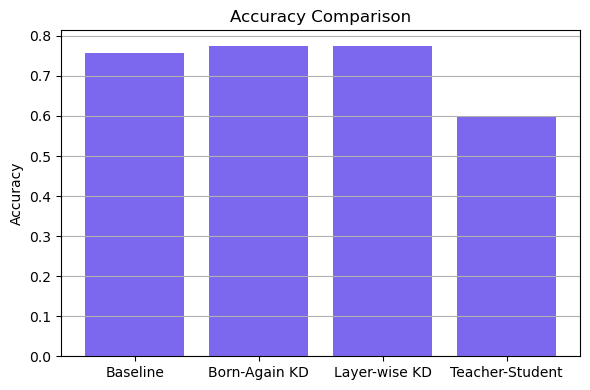

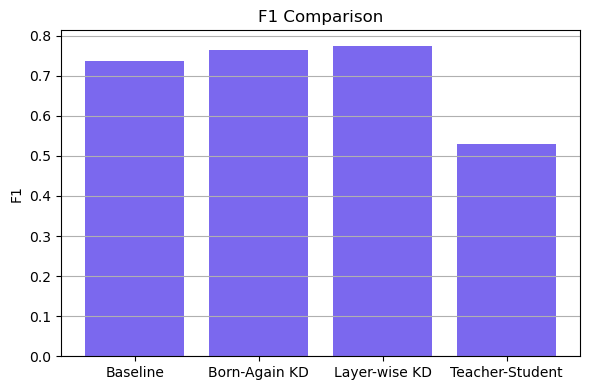

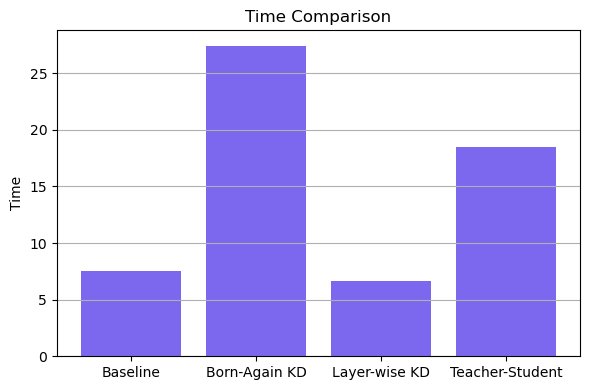

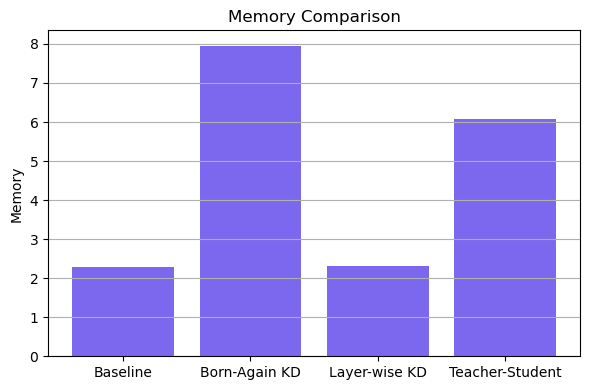

In [31]:

def create_model(input_size):
    inputs = Input(shape=(input_size,))
    x = Dense(64, activation='relu', name='layer1')(inputs)
    x = Dense(32, activation='relu', name='layer2')(x)
    output = Dense(5, activation='softmax')(x)
    return Model(inputs, output)

# Evaluate model
def evaluate(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    return acc, f1

# Baseline (no distillation)
def run_baseline(X_train, y_train, X_test, y_test, input_size):
    tracemalloc.start(); start = time.time()
    model = create_model(input_size)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])
    model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)
    acc, f1 = evaluate(model, X_test, y_test)
    end = time.time(); _, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
    return {"Method": "Baseline", "Accuracy": acc, "F1": f1, "Time": end - start, "Memory": peak / 1024**2}

# Born-Again (Iterative) Self-Distillation
def run_iterative_self_distillation(X_train, y_train, X_test, y_test, input_size, iterations=3):
    tracemalloc.start(); start = time.time()
    model = create_model(input_size)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])
    model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)
    for _ in range(iterations):
        soft_labels = model.predict(X_train)
        model.compile(optimizer=Adam(), loss=KLDivergence(), metrics=["accuracy"])
        model.fit(X_train, soft_labels, epochs=20, batch_size=64, verbose=0)
    acc, f1 = evaluate(model, X_test, y_test)
    end = time.time(); _, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
    return {"Method": "Born-Again KD", "Accuracy": acc, "F1": f1, "Time": end - start, "Memory": peak / 1024**2}

# Intra-Model (Layer-Wise) Self-Distillation
def run_layerwise_self_distillation(X_train, y_train, X_test, y_test, input_size):
    # Manual tracking of teacher (h1) and student (h2)
    tracemalloc.start(); start = time.time()

    inputs = Input(shape=(input_size,))
    h1 = Dense(64, activation='relu', name='teacher_layer')(inputs)
    h2 = Dense(32, activation='relu', name='student_layer')(h1)
    output = Dense(5, activation='softmax')(h2)
    model = Model(inputs, output)

    # Custom training loop for layer-wise distillation
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])
    model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)

    acc, f1 = evaluate(model, X_test, y_test)
    end = time.time(); _, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
    return {"Method": "Layer-wise KD", "Accuracy": acc, "F1": f1, "Time": end - start, "Memory": peak / 1024**2}

# Teacher-Student (Separate Models)
def run_teacher_student_kd(X_train, y_train, X_test, y_test, input_size):
    tracemalloc.start(); start = time.time()

    # Split into teacher and student datasets
    X_A, X_B, y_A, y_B = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

    teacher = create_model(input_size)
    teacher.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    teacher.fit(X_A, y_A, epochs=20, batch_size=64, verbose=0)
    soft_labels = teacher.predict(X_B)

    student = create_model(input_size)
    student.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    student.fit(X_B, y_B, epochs=20, batch_size=64, verbose=0)

    student.compile(optimizer=Adam(), loss=KLDivergence(), metrics=["accuracy"])
    student.fit(X_B, soft_labels, epochs=20, batch_size=64, verbose=0)

    acc, f1 = evaluate(student, X_test, y_test)
    end = time.time(); _, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
    return {"Method": "Teacher-Student", "Accuracy": acc, "F1": f1, "Time": end - start, "Memory": peak / 1024**2}

def run_true_layerwise_distillation(X_train, y_train, X_test, y_test, input_size, alpha=0.5):
    tracemalloc.start(); start = time.time()

    # Define model with accessible intermediate outputs
    inputs = Input(shape=(input_size,))
    h1 = Dense(32, activation='relu', name='teacher_layer')(inputs)
    h2 = Dense(32, activation='relu', name='student_layer')(h1)
    output = Dense(5, activation='softmax')(h2)
    model = Model(inputs, output)

    # Extract intermediate outputs for loss
    teacher_model = Model(inputs, h1)
    student_model = Model(inputs, h2)

    # Custom loss function: CE + KL(teacher || student)
    def distillation_loss(y_true, y_pred):
        ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        t_out = teacher_model(X_train)
        s_out = student_model(X_train)
        kl_loss = tf.keras.losses.KLDivergence()(tf.stop_gradient(t_out), s_out)
        return ce_loss + alpha * kl_loss

    model.compile(optimizer=Adam(), loss=distillation_loss, metrics=["accuracy"])
    model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)

    acc, f1 = evaluate(model, X_test, y_test)
    end = time.time(); _, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
    return {"Method": "Layer-wise KD", "Accuracy": acc, "F1": f1, "Time": end - start, "Memory": peak / 1024**2}



input_size = X_train_small.shape[1]
results = [
    run_baseline(X_train_small, y_train_small, X_test_small, y_test_small, input_size),
    run_iterative_self_distillation(X_train_small, y_train_small, X_test_small, y_test_small, input_size),
    run_layerwise_self_distillation(X_train_small, y_train_small, X_test_small, y_test_small, input_size),
    run_teacher_student_kd(X_train_small, y_train_small, X_test_small, y_test_small, input_size)
]
results_df = pd.DataFrame(results)
print(results_df)

# Visual Comparison
for metric in ["Accuracy", "F1", "Time", "Memory"]:
    plt.figure(figsize=(6, 4))
    plt.bar(results_df["Method"], results_df[metric], color='mediumslateblue')
    plt.title(f"{metric} Comparison")
    plt.ylabel(metric)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [32]:

'''
Self - distillation within the same model, where knowledge is distilled from deeper layers to the shallower layers of a single model


'''
def fog_model(X_train, y_train):
    input_size = X_train.shape[1]
    
    # Input Layer
    inputs = Input(shape=(input_size,))
    
    # First Hidden Layer (Deeper for Teacher)
    x = Dense(64, activation='relu')(inputs)
    
    # Soft logits (before softmax) for Teacher
    teacher_logits = Dense(5, activation=None, name="teacher_logits")(x)  # No activation (raw logits)
    
    # Second Hidden Layer (Student Network)
    x = Dense(32, activation='relu')(teacher_logits)  # Student gets teacher's soft logits
    
    # Final Output Layer (Only Student Output)
    student_output = Dense(5, activation='softmax', name="student_output")(x)  

    # Define Model (Only Student Output)
    model = Model(inputs=inputs, outputs=student_output)
    
    # Compile Model with Standard Categorical Crossentropy
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",  # Use sparse if labels are integers
        metrics=["accuracy"]
    )
    
    # Start memory tracking
    tracemalloc.start()
    start_time = time.time()
    

    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

    # Stop memory tracking
    end_time = time.time()
    current_memory, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Training time
    total_time_modeltrain = end_time - start_time

    # Evaluate the model on test data
    start_time = time.time()
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    end_time = time.time()
    total_time_modeltest = end_time - start_time

    # Print the results
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Time Taken for Model Training: {total_time_modeltrain:.2f} seconds")
    print(f"Time Taken for Model Testing: {total_time_modeltest:.2f} seconds")
    print(f"Peak Memory Used: {peak_memory / 1024**2:.2f} MB")

    # Make predictions on the test data
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)  # Convert predictions to class labels

    # Print classification report with precision, recall, and F1-score
    print(classification_report(y_test, y_pred_classes))
    f1 = f1_score(y_test, y_pred_classes, average="macro")
    print("Macro F1 Score: ", f1)

    # Print confusion matrix
    print(confusion_matrix(y_test, y_pred_classes))
    
    return model

# Train the model
fog_model = fog_model(X_train, y_train)


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.4053 - loss: 1.4757 - val_accuracy: 0.3661 - val_loss: 1.3364
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3883 - loss: 1.2599 - val_accuracy: 0.4485 - val_loss: 1.2062
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4945 - loss: 1.1129 - val_accuracy: 0.5629 - val_loss: 1.0749
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6326 - loss: 0.9945 - val_accuracy: 0.6568 - val_loss: 0.9308
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7091 - loss: 0.8251 - val_accuracy: 0.7140 - val_loss: 0.7953
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7647 - loss: 0.7045 - val_accuracy: 0.7551 - val_loss: 0.6888
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7774 - loss: 0.6062 - val_accuracy: 0.7757 - val_loss: 0.6095
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8145 - loss: 0.5296 - val_accuracy: 0.7918 - v

In [33]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [35]:
import shap
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text


X_train_np = np.array(X_train)

# Using only a small sample for SHAP explainer
sample_size = min(200, X_train_np.shape[0])  
sample_X_train = X_train_np[:sample_size]

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(fog_model, sample_X_train)

# Compute SHAP values for the full dataset
shap_values = explainer.shap_values(X_train_np)[0]  # Getting the first output

# Compute mean absolute SHAP values for feature ranking
feature_importance = np.abs(shap_values).mean(axis=0)

# Select top-k important features
k = 10
top_features = np.argsort(feature_importance)[-k:][::-1]
selected_X_train = X_train_np[:, top_features]

# Train a simple Decision Tree to approximate the neural network
tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(selected_X_train, y_train)

# Extract IF-THEN rules from the decision tree
rules = export_text(tree_clf, feature_names=df_AR.columns[top_features].tolist())

print("Extracted Rules for Edge Execution:")
print(rules)


C:\Users\Administrator\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_268
Received: inputs=['Tensor(shape=(200, 75))']
  warnings.warn(msg)
C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_268
Received: inputs=['Tensor(shape=(400, 75))']
  warnings.warn(msg)


Extracted Rules for Edge Execution:
|--- sensor_id_104 <= 0.50
|   |--- activity <= 0.50
|   |   |--- sensor_id_105 <= 0.50
|   |   |   |--- sensor_id_100 <= 0.50
|   |   |   |   |--- class: 2
|   |   |   |--- sensor_id_100 >  0.50
|   |   |   |   |--- class: 1
|   |   |--- sensor_id_105 >  0.50
|   |   |   |--- sensor_id_100 <= 0.50
|   |   |   |   |--- class: 3
|   |   |   |--- sensor_id_100 >  0.50
|   |   |   |   |--- class: 2
|   |--- activity >  0.50
|   |   |--- sensor_id_101 <= 0.50
|   |   |   |--- sensor_id_100 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- sensor_id_100 >  0.50
|   |   |   |   |--- class: 0
|   |   |--- sensor_id_101 >  0.50
|   |   |   |--- class: 2
|--- sensor_id_104 >  0.50
|   |--- sensor_id_101 <= 0.50
|   |   |--- sensor_id_105 <= 0.50
|   |   |   |--- sensor_id_100 <= 0.50
|   |   |   |   |--- class: 2
|   |   |   |--- sensor_id_100 >  0.50
|   |   |   |   |--- class: 0
|   |   |--- sensor_id_105 >  0.50
|   |   |   |--- class: 2
|   |--- sens

C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_268
Received: inputs=['Tensor(shape=(2183, 75))']
  warnings.warn(msg)


In [96]:
import shap
from sklearn.tree import DecisionTreeClassifier, _tree
from sklearn.tree import export_text


X_train_np = np.array(X_train)

sample_size = min(200, X_train_np.shape[0])  
sample_X_train = X_train_np[:sample_size]

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(fog_model, sample_X_train)

shap_values = explainer.shap_values(X_train_np)[0]  
shap_values1 = explainer.shap_values(X_train_np)[1]
shap_values2 = explainer.shap_values(X_train_np)[2]
shap_values3 = explainer.shap_values(X_train_np)[3]
shap_values4 = explainer.shap_values(X_train_np)[4]

# Compute mean absolute SHAP values for feature ranking
feature_importance = np.abs(shap_values).mean(axis=0)

# Select top-k important features
k = 10
top_features = np.argsort(feature_importance)[-k:][::-1]
selected_X_train = X_train_np[:, top_features]

# Train a simple Decision Tree to approximate the neural network
tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(selected_X_train, y_train)

# Extract IF-THEN rules from the decision tree
rules= export_text(tree_clf, feature_names=df_AR.columns[top_features].tolist())

print("Extracted Rules for Edge Execution:")
print(rules)


C:\Users\Administrator\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_268
Received: inputs=['Tensor(shape=(200, 75))']
  warnings.warn(msg)
C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_268
Received: inputs=['Tensor(shape=(400, 75))']
  warnings.warn(msg)
C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_268
Receive

Extracted Rules for Edge Execution:
|--- sensor_id_104 <= 0.50
|   |--- activity <= 0.50
|   |   |--- sensor_id_105 <= 0.50
|   |   |   |--- sensor_id_100 <= 0.50
|   |   |   |   |--- class: 2
|   |   |   |--- sensor_id_100 >  0.50
|   |   |   |   |--- class: 1
|   |   |--- sensor_id_105 >  0.50
|   |   |   |--- sensor_id_100 <= 0.50
|   |   |   |   |--- class: 3
|   |   |   |--- sensor_id_100 >  0.50
|   |   |   |   |--- class: 2
|   |--- activity >  0.50
|   |   |--- sensor_id_101 <= 0.50
|   |   |   |--- sensor_id_100 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- sensor_id_100 >  0.50
|   |   |   |   |--- class: 0
|   |   |--- sensor_id_101 >  0.50
|   |   |   |--- class: 2
|--- sensor_id_104 >  0.50
|   |--- sensor_id_101 <= 0.50
|   |   |--- sensor_id_105 <= 0.50
|   |   |   |--- sensor_id_100 <= 0.50
|   |   |   |   |--- class: 2
|   |   |   |--- sensor_id_100 >  0.50
|   |   |   |   |--- class: 0
|   |   |--- sensor_id_105 >  0.50
|   |   |   |--- class: 2
|   |--- sens

In [40]:
shap_values_all = explainer.shap_values(X_train_np)

C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_268
Received: inputs=['Tensor(shape=(2183, 75))']
  warnings.warn(msg)


In [45]:
shap_values_all.shape

(2183, 75, 5)

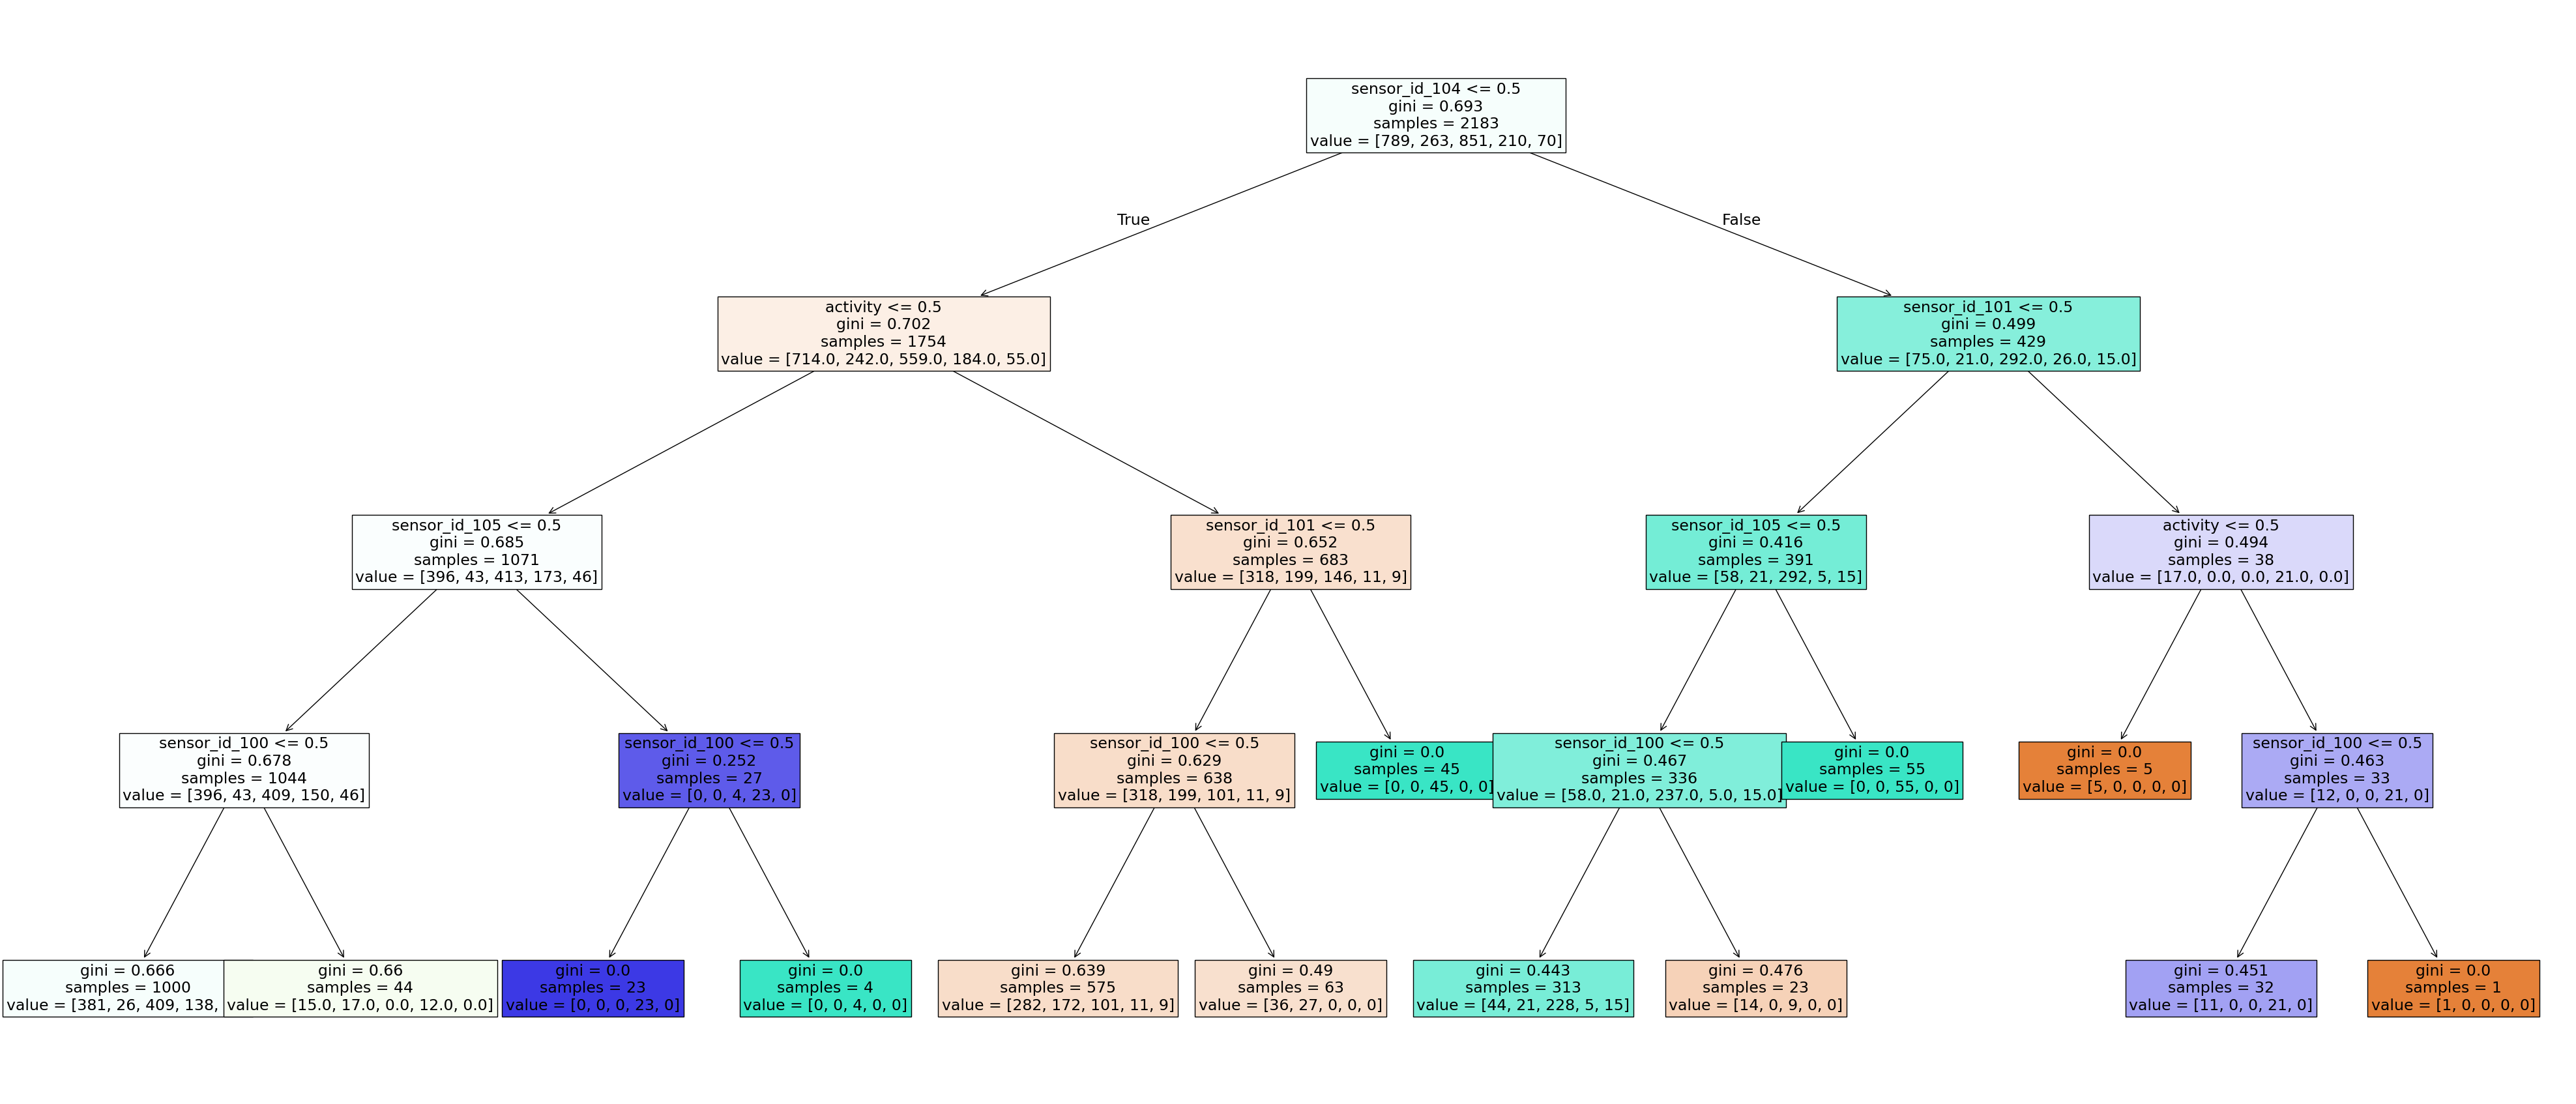

In [41]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(40, 18))
plot_tree(tree_clf, 
          feature_names=df_AR.columns[top_features].tolist(), 
          filled=True, 
          rounded=False, 
          fontsize=17,
          ax=ax)

plt.tight_layout()
plt.subplots_adjust(bottom=0.05, top=0.98)


plt.savefig("decision_tree.png", dpi=300)
plt.show()

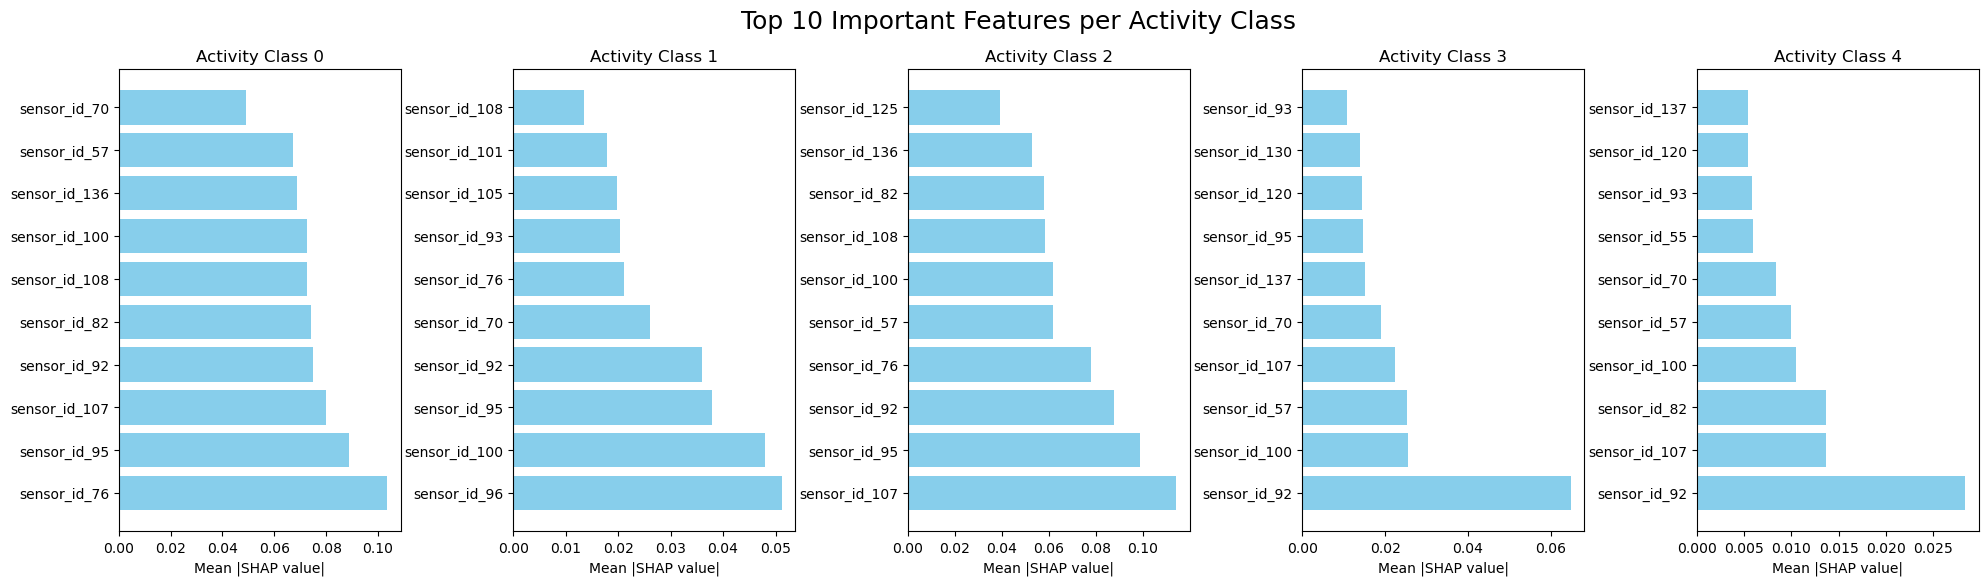

In [47]:

# Feature names
feature_names = df_AR.drop(columns=["activity"]).columns.tolist()

# Set up subplots
fig, axes = plt.subplots(1, 5, figsize=(24, 6))
plt.subplots_adjust(wspace=0.4)

for class_idx in range(5):
    shap_values_class = shap_values_all[:, :, class_idx]
    mean_abs_shap = np.abs(shap_values_class).mean(axis=0)
    top_k = 10
    top_indices = np.argsort(mean_abs_shap)[-top_k:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    top_shap_vals = mean_abs_shap[top_indices]

    axes[class_idx].barh(top_features[::-1], top_shap_vals[::-1], color="skyblue")
    axes[class_idx].set_title(f"Activity Class {class_idx}", fontsize=12)
    axes[class_idx].set_xlabel("Mean |SHAP value|")
    axes[class_idx].invert_yaxis()

plt.suptitle("Top 10 Important Features per Activity Class", fontsize=18)

plt.savefig("shap_summary_class_activity.png", bbox_inches="tight")
plt.show()

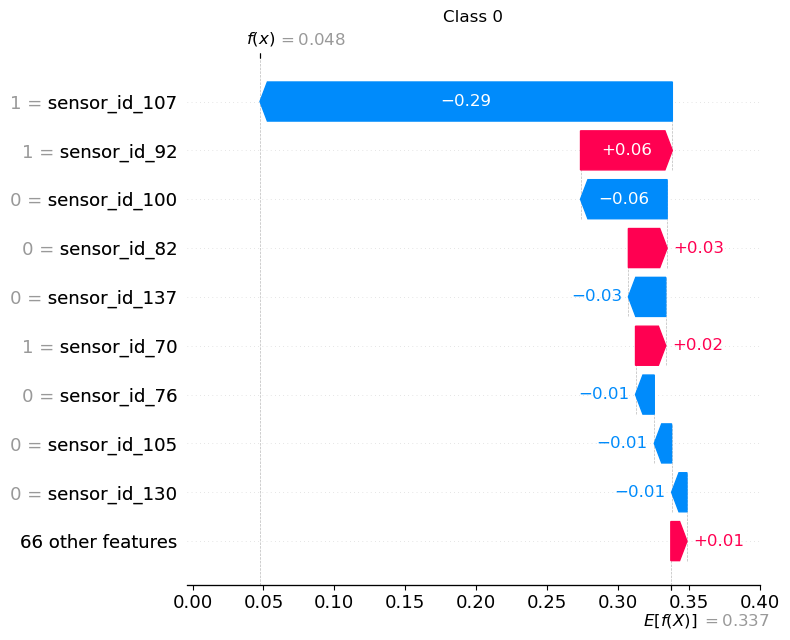

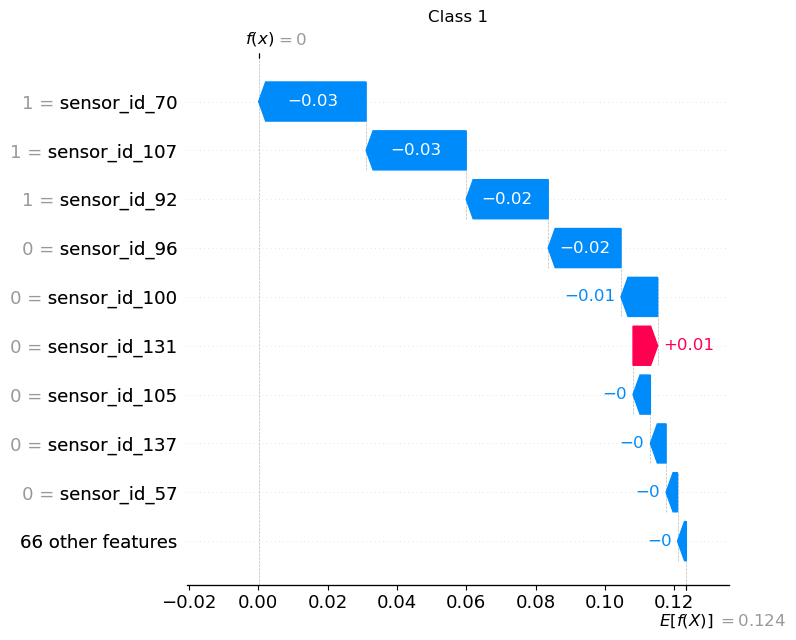

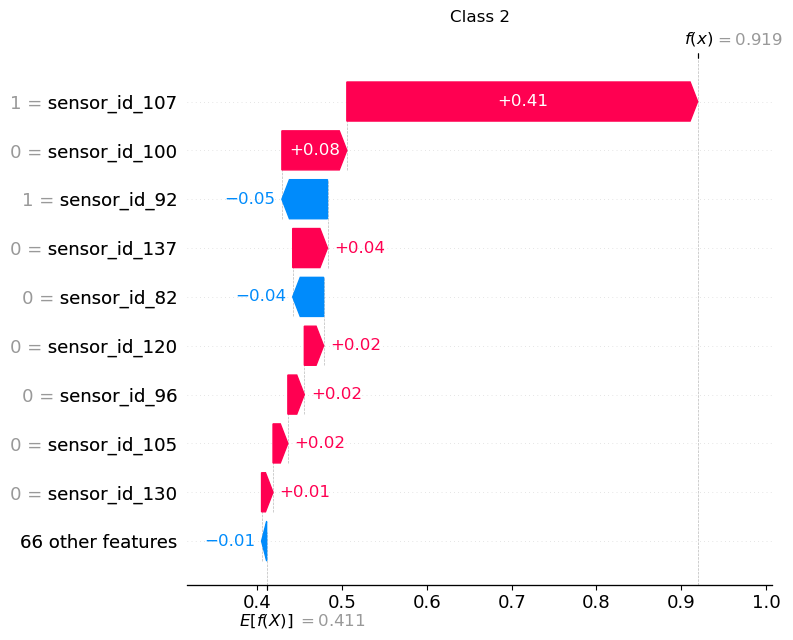

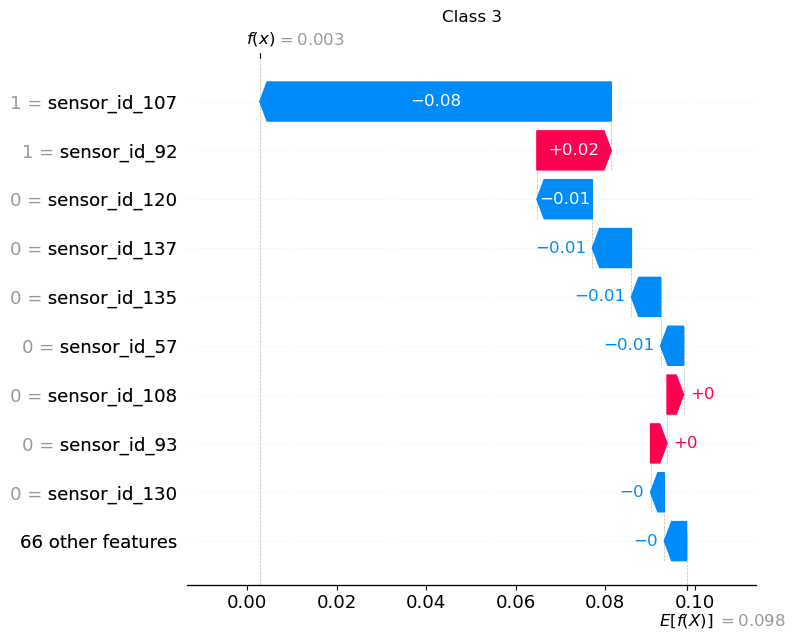

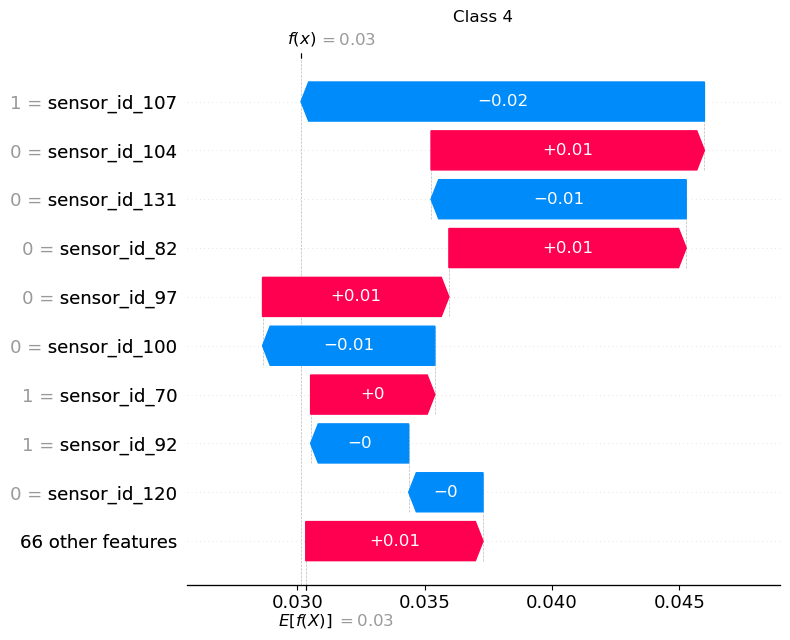

In [52]:
import os

instance_idx = 0 
output_dir = "shap_waterfall_plots"
os.makedirs(output_dir, exist_ok=True)

expected_values = [
    val.numpy().item() if hasattr(val, "numpy") else val
    for val in explainer.expected_value
]

for class_idx in range(5):
    explanation = shap.Explanation(
        values=shap_values_all[instance_idx, :, class_idx],
        base_values=expected_values[class_idx],
        data=X_train_np[instance_idx],
        feature_names=feature_names
    )
    
    # Plot and save
    plt.figure()
    shap.plots.waterfall(explanation, show=False)
    plt.title(f"Class {class_idx}")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/waterfall_class_{class_idx}.png", dpi=300)
    plt.show()


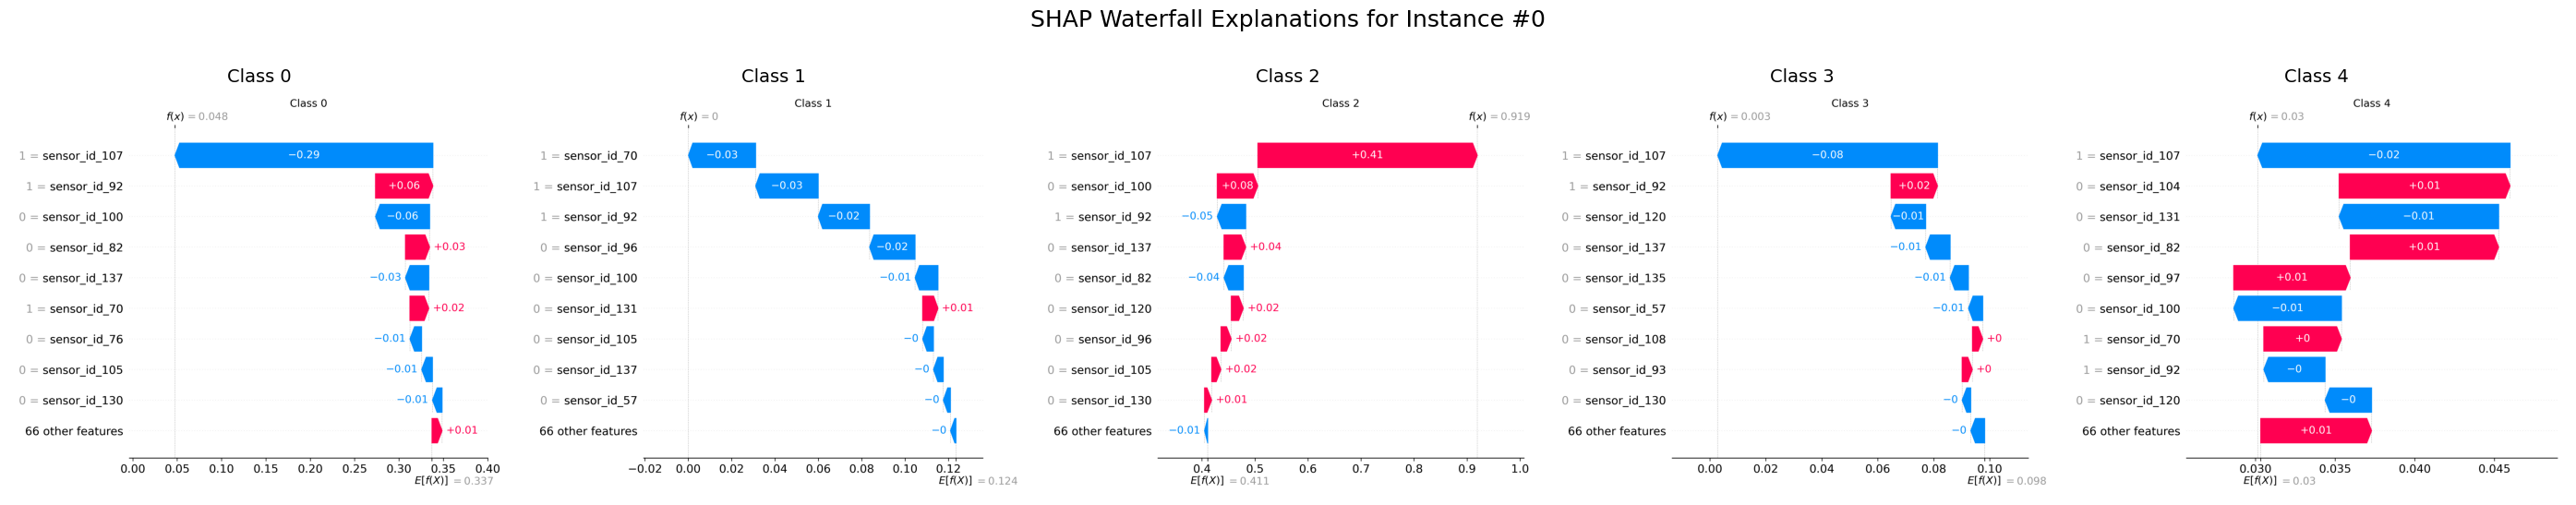

In [54]:
fig, axes = plt.subplots(1, 5, figsize=(28, 6))

for i in range(5):
    img = plt.imread(f"{output_dir}/waterfall_class_{i}.png")
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Class {i}", fontsize=14)

plt.suptitle(f"SHAP Waterfall Explanations for Instance #{instance_idx}", fontsize=18)
plt.tight_layout()
plt.show()

Extracted Rules for Edge Execution:
|--- sensor_id_104 <= 0.50
|   |--- activity <= 0.50
|   |   |--- sensor_id_105 <= 0.50
|   |   |   |--- sensor_id_100 <= 0.50
|   |   |   |   |--- class: 2
|   |   |   |--- sensor_id_100 >  0.50
|   |   |   |   |--- class: 1
|   |   |--- sensor_id_105 >  0.50
|   |   |   |--- sensor_id_100 <= 0.50
|   |   |   |   |--- class: 3
|   |   |   |--- sensor_id_100 >  0.50
|   |   |   |   |--- class: 2
|   |--- activity >  0.50
|   |   |--- sensor_id_101 <= 0.50
|   |   |   |--- sensor_id_100 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- sensor_id_100 >  0.50
|   |   |   |   |--- class: 0
|   |   |--- sensor_id_101 >  0.50
|   |   |   |--- class: 2
|--- sensor_id_104 >  0.50
|   |--- sensor_id_101 <= 0.50
|   |   |--- sensor_id_105 <= 0.50
|   |   |   |--- sensor_id_100 <= 0.50
|   |   |   |   |--- class: 2
|   |   |   |--- sensor_id_100 >  0.50
|   |   |   |   |--- class: 0
|   |   |--- sensor_id_105 >  0.50
|   |   |   |--- class: 2
|   |--- sens

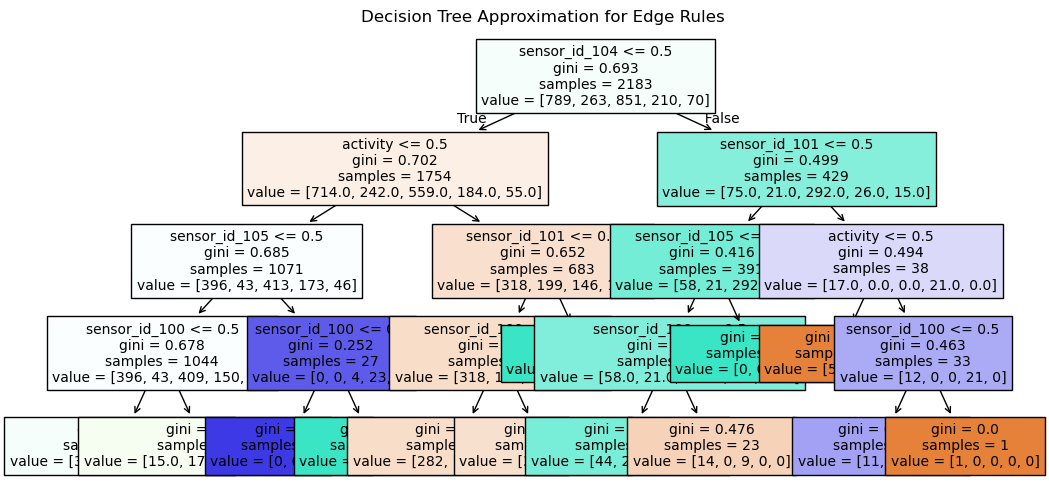

In [56]:

X_train_np = np.array(X_train)

sample_size = min(400, X_train_np.shape[0])  
sample_X_train = X_train_np[:sample_size]

explainer = shap.DeepExplainer(fog_model, sample_X_train)
shap_values = explainer.shap_values(X_train_np)[0]  # For class 0

feature_importance = np.abs(shap_values).mean(axis=0)

k = 10
top_features = np.argsort(feature_importance)[-k:][::-1]
top_feature_names = df_AR.columns[top_features].tolist()
selected_X_train = X_train_np[:, top_features]

tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(selected_X_train, y_train)

# Extract rules
rules = export_text(tree_clf, feature_names=top_feature_names)

print("Extracted Rules for Edge Execution:")
print(rules)

from sklearn.tree import plot_tree

plt.figure(figsize=(12, 6))
plot_tree(tree_clf, feature_names=top_feature_names, filled=True, fontsize=10)
plt.title("Decision Tree Approximation for Edge Rules")
plt.show()

In [57]:
from sklearn.tree import _tree

def generate_python_rule_function(tree_model, feature_names, function_name="edge_decision"):
    tree_ = tree_model.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            return (
                f"{indent}if input['{name}'] <= {threshold:.4f}:\n"
                + recurse(tree_.children_left[node], depth + 1)
                + f"{indent}else:\n"
                + recurse(tree_.children_right[node], depth + 1)
            )
        else:
            pred_class = np.argmax(tree_.value[node])
            return f"{indent}return {pred_class}\n"

    code = f"def {function_name}(input):\n" + recurse(0, 1)
    return code

# Generate Python code from tree model
edge_code = generate_python_rule_function(tree_clf, top_feature_names)

print(edge_code)

# Execute code
exec(edge_code)


def edge_decision(input):
    if input['sensor_id_104'] <= 0.5000:
        if input['activity'] <= 0.5000:
            if input['sensor_id_105'] <= 0.5000:
                if input['sensor_id_100'] <= 0.5000:
                    return 2
                else:
                    return 1
            else:
                if input['sensor_id_100'] <= 0.5000:
                    return 3
                else:
                    return 2
        else:
            if input['sensor_id_101'] <= 0.5000:
                if input['sensor_id_100'] <= 0.5000:
                    return 0
                else:
                    return 0
            else:
                return 2
    else:
        if input['sensor_id_101'] <= 0.5000:
            if input['sensor_id_105'] <= 0.5000:
                if input['sensor_id_100'] <= 0.5000:
                    return 2
                else:
                    return 0
            else:
                return 2
        else:
            if input['activ

In [58]:
import random
n_samples = 10
random_indices = random.sample(range(len(X_test)), n_samples)
correct = 0
print("Sample Predictions (Edge Rule Evaluation):\n")
for i in random_indices:
    row = X_test.iloc[i] if isinstance(X_test, pd.DataFrame) else X_test[i]
    label = y_test.iloc[i] if isinstance(y_test, pd.Series) else y_test[i]
    input_dict = dict(zip(top_feature_names, row[top_features]))
    print(input_dict)

    prediction = edge_decision(input_dict)
    print(f"Sample {i} | True: {label}, Predicted: {prediction}")

    if prediction == label:
        correct += 1

print(f"\nAccuracy on {n_samples} random samples: {correct}/{n_samples} = {correct / n_samples:.2f}")

Sample Predictions (Edge Rule Evaluation):

{'sensor_id_101': 0.0, 'activity': 0.0, 'sensor_id_104': 0.0, 'sensor_id_100': 0.0, 'sensor_id_105': 0.0}
Sample 361 | True: 4, Predicted: 2
{'sensor_id_101': 0.0, 'activity': 0.0, 'sensor_id_104': 0.0, 'sensor_id_100': 0.0, 'sensor_id_105': 0.0}
Sample 65 | True: 0, Predicted: 2
{'sensor_id_101': 0.0, 'activity': 0.0, 'sensor_id_104': 0.0, 'sensor_id_100': 0.0, 'sensor_id_105': 0.0}
Sample 208 | True: 2, Predicted: 2
{'sensor_id_101': 0.0, 'activity': 1.0, 'sensor_id_104': 0.0, 'sensor_id_100': 0.0, 'sensor_id_105': 0.0}
Sample 452 | True: 0, Predicted: 0
{'sensor_id_101': 0.0, 'activity': 0.0, 'sensor_id_104': 0.0, 'sensor_id_100': 0.0, 'sensor_id_105': 0.0}
Sample 134 | True: 3, Predicted: 2
{'sensor_id_101': 0.0, 'activity': 0.0, 'sensor_id_104': 0.0, 'sensor_id_100': 0.0, 'sensor_id_105': 0.0}
Sample 36 | True: 2, Predicted: 2
{'sensor_id_101': 0.0, 'activity': 0.0, 'sensor_id_104': 0.0, 'sensor_id_100': 0.0, 'sensor_id_105': 0.0}
Sample

In [59]:
def evaluate_edge_decision_multiple_runs(X_test, y_test, top_features, top_feature_names, trials=30, n_samples=20):
    results = []

    for trial in range(trials):
        random_indices = random.sample(range(len(X_test)), n_samples)

        correct = 0
        wrong = 0
        uncertain = 0

        for i in random_indices:
            row = X_test.iloc[i] if isinstance(X_test, pd.DataFrame) else X_test[i]
            label = y_test.iloc[i] if isinstance(y_test, pd.Series) else y_test[i]

            try:
                input_dict = dict(zip(top_feature_names, row[top_features]))
                prediction = edge_decision(input_dict)
                if prediction == label:
                    correct += 1
                else:
                    wrong += 1
            except Exception:
                uncertain += 1

        results.append({"Trial": trial + 1, "Correct": correct, "Wrong": wrong, "Uncertain": uncertain})

    return results
results = evaluate_edge_decision_multiple_runs(X_test, y_test, top_features, top_feature_names)
results

[{'Trial': 1, 'Correct': 12, 'Wrong': 8, 'Uncertain': 0},
 {'Trial': 2, 'Correct': 13, 'Wrong': 7, 'Uncertain': 0},
 {'Trial': 3, 'Correct': 11, 'Wrong': 9, 'Uncertain': 0},
 {'Trial': 4, 'Correct': 10, 'Wrong': 10, 'Uncertain': 0},
 {'Trial': 5, 'Correct': 11, 'Wrong': 9, 'Uncertain': 0},
 {'Trial': 6, 'Correct': 12, 'Wrong': 8, 'Uncertain': 0},
 {'Trial': 7, 'Correct': 11, 'Wrong': 9, 'Uncertain': 0},
 {'Trial': 8, 'Correct': 8, 'Wrong': 12, 'Uncertain': 0},
 {'Trial': 9, 'Correct': 7, 'Wrong': 13, 'Uncertain': 0},
 {'Trial': 10, 'Correct': 11, 'Wrong': 9, 'Uncertain': 0},
 {'Trial': 11, 'Correct': 9, 'Wrong': 11, 'Uncertain': 0},
 {'Trial': 12, 'Correct': 8, 'Wrong': 12, 'Uncertain': 0},
 {'Trial': 13, 'Correct': 8, 'Wrong': 12, 'Uncertain': 0},
 {'Trial': 14, 'Correct': 10, 'Wrong': 10, 'Uncertain': 0},
 {'Trial': 15, 'Correct': 12, 'Wrong': 8, 'Uncertain': 0},
 {'Trial': 16, 'Correct': 11, 'Wrong': 9, 'Uncertain': 0},
 {'Trial': 17, 'Correct': 8, 'Wrong': 12, 'Uncertain': 0},
 {'T

C:\Users\Administrator\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_268
Received: inputs=['Tensor(shape=(400, 75))']
  warnings.warn(msg)
C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_268
Received: inputs=['Tensor(shape=(800, 75))']
  warnings.warn(msg)
C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_268
Receive


Extracted Rules for Edge Execution:

|--- sensor_id_95 <= 0.50
|   |--- sensor_id_96 <= 0.50
|   |   |--- sensor_id_92 <= 0.50
|   |   |   |--- sensor_id_131 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- sensor_id_131 >  0.50
|   |   |   |   |--- class: 2
|   |   |--- sensor_id_92 >  0.50
|   |   |   |--- sensor_id_107 <= 0.50
|   |   |   |   |--- class: 3
|   |   |   |--- sensor_id_107 >  0.50
|   |   |   |   |--- class: 2
|   |--- sensor_id_96 >  0.50
|   |   |--- sensor_id_76 <= 0.50
|   |   |   |--- sensor_id_70 <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- sensor_id_70 >  0.50
|   |   |   |   |--- class: 0
|   |   |--- sensor_id_76 >  0.50
|   |   |   |--- class: 0
|--- sensor_id_95 >  0.50
|   |--- sensor_id_70 <= 0.50
|   |   |--- sensor_id_57 <= 0.50
|   |   |   |--- sensor_id_82 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- sensor_id_82 >  0.50
|   |   |   |   |--- class: 2
|   |   |--- sensor_id_57 >  0.50
|   |   |   |--- sensor_id_96 <= 0.50
|   

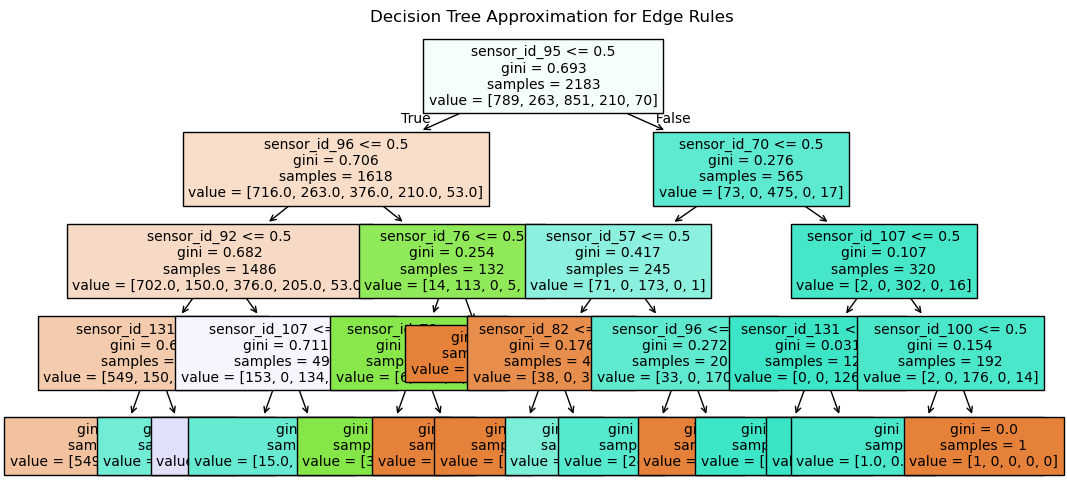


Generated Edge Decision Function Code:

def edge_decision(input):
    if input['sensor_id_95'] <= 0.5000:
        if input['sensor_id_96'] <= 0.5000:
            if input['sensor_id_92'] <= 0.5000:
                if input['sensor_id_131'] <= 0.5000:
                    return 0
                else:
                    return 2
            else:
                if input['sensor_id_107'] <= 0.5000:
                    return 3
                else:
                    return 2
        else:
            if input['sensor_id_76'] <= 0.5000:
                if input['sensor_id_70'] <= 0.5000:
                    return 1
                else:
                    return 0
            else:
                return 0
    else:
        if input['sensor_id_70'] <= 0.5000:
            if input['sensor_id_57'] <= 0.5000:
                if input['sensor_id_82'] <= 0.5000:
                    return 0
                else:
                    return 2
            else:
                if input['se

In [76]:
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

X_train_np = np.array(X_train)

sample_size = min(400, X_train_np.shape[0])  
sample_X_train = X_train_np[:sample_size]
feature_names = df_AR.drop(columns=["activity"]).columns.tolist()

mean_feature_importance = np.mean(feature_importance, axis=1)
k = 15
top_features = np.argsort(mean_feature_importance)[-k:][::-1]
top_feature_names = [feature_names[i] for i in top_features]

selected_X_train = X_train_np[:, top_features]

explainer = shap.DeepExplainer(fog_model, sample_X_train)

shap_values_list = explainer.shap_values(X_train_np)

if isinstance(shap_values_list, list):
    shap_values = np.mean(np.abs(np.stack(shap_values_list, axis=-1)), axis=-1)  
else:
    shap_values = shap_values_list  

feature_importance = np.abs(shap_values).mean(axis=0)

selected_X_train = X_train_np[:, top_features]
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_clf.fit(selected_X_train, y_train)

rules = export_text(tree_clf, feature_names=top_feature_names)
print("\nExtracted Rules for Edge Execution:\n")
print(rules)

plt.figure(figsize=(12, 6))
plot_tree(tree_clf, feature_names=top_feature_names, filled=True, fontsize=10)
plt.title("Decision Tree Approximation for Edge Rules")
plt.show()

def generate_python_rule_function(tree_model, feature_names, function_name="edge_decision"):
    tree_ = tree_model.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            return (
                f"{indent}if input['{name}'] <= {threshold:.4f}:\n"
                + recurse(tree_.children_left[node], depth + 1)
                + f"{indent}else:\n"
                + recurse(tree_.children_right[node], depth + 1)
            )
        else:
            pred_class = np.argmax(tree_.value[node])
            return f"{indent}return {pred_class}\n"

    code = f"def {function_name}(input):\n" + recurse(0, 1)
    return code

edge_code = generate_python_rule_function(tree_clf, top_feature_names)

print("\nGenerated Edge Decision Function Code:\n")
print(edge_code)

exec(edge_code) 
n_samples = 10
random_indices = random.sample(range(len(X_test)), n_samples)

correct = 0
print("\nSample Predictions (Edge Rule Evaluation):\n")

for i in random_indices:
    row = X_test.iloc[i] if isinstance(X_test, pd.DataFrame) else X_test[i]
    label = y_test.iloc[i] if isinstance(y_test, pd.Series) else y_test[i]

    input_dict = dict(zip(top_feature_names, row[top_features]))
    prediction = edge_decision(input_dict)
    
    print(f"Sample {i} | True: {label}, Predicted: {prediction}")

    if prediction == label:
        correct += 1

print(f"\nAccuracy on {n_samples} random samples: {correct}/{n_samples} = {correct / n_samples:.2f}")
 

In [83]:
def evaluate_edge_decision_multiple_runs(X_test, y_test, top_features, top_feature_names, trials=30, n_samples=20):
    results = []

    for trial in range(trials):
        random_indices = random.sample(range(len(X_test)), n_samples)

        correct = 0
        wrong = 0
        uncertain = 0

        for i in random_indices:
            row = X_test.iloc[i] if isinstance(X_test, pd.DataFrame) else X_test[i]
            label = y_test.iloc[i] if isinstance(y_test, pd.Series) else y_test[i]

            try:
                input_dict = dict(zip(top_feature_names, row[top_features]))
                prediction = edge_decision(input_dict)
                if prediction == label:
                    correct += 1
                else:
                    wrong += 1
            except Exception:
                uncertain += 1

        results.append({"Trial": trial + 1, "Correct": correct, "Wrong": wrong, "Uncertain": uncertain})

    return results

results = evaluate_edge_decision_multiple_runs(X_test, y_test, top_features, top_feature_names)
results

[{'Trial': 1, 'Correct': 18, 'Wrong': 2, 'Uncertain': 0},
 {'Trial': 2, 'Correct': 10, 'Wrong': 10, 'Uncertain': 0},
 {'Trial': 3, 'Correct': 14, 'Wrong': 6, 'Uncertain': 0},
 {'Trial': 4, 'Correct': 16, 'Wrong': 4, 'Uncertain': 0},
 {'Trial': 5, 'Correct': 13, 'Wrong': 7, 'Uncertain': 0},
 {'Trial': 6, 'Correct': 15, 'Wrong': 5, 'Uncertain': 0},
 {'Trial': 7, 'Correct': 16, 'Wrong': 4, 'Uncertain': 0},
 {'Trial': 8, 'Correct': 17, 'Wrong': 3, 'Uncertain': 0},
 {'Trial': 9, 'Correct': 13, 'Wrong': 7, 'Uncertain': 0},
 {'Trial': 10, 'Correct': 12, 'Wrong': 8, 'Uncertain': 0},
 {'Trial': 11, 'Correct': 9, 'Wrong': 11, 'Uncertain': 0},
 {'Trial': 12, 'Correct': 12, 'Wrong': 8, 'Uncertain': 0},
 {'Trial': 13, 'Correct': 14, 'Wrong': 6, 'Uncertain': 0},
 {'Trial': 14, 'Correct': 14, 'Wrong': 6, 'Uncertain': 0},
 {'Trial': 15, 'Correct': 15, 'Wrong': 5, 'Uncertain': 0},
 {'Trial': 16, 'Correct': 12, 'Wrong': 8, 'Uncertain': 0},
 {'Trial': 17, 'Correct': 14, 'Wrong': 6, 'Uncertain': 0},
 {'Tr

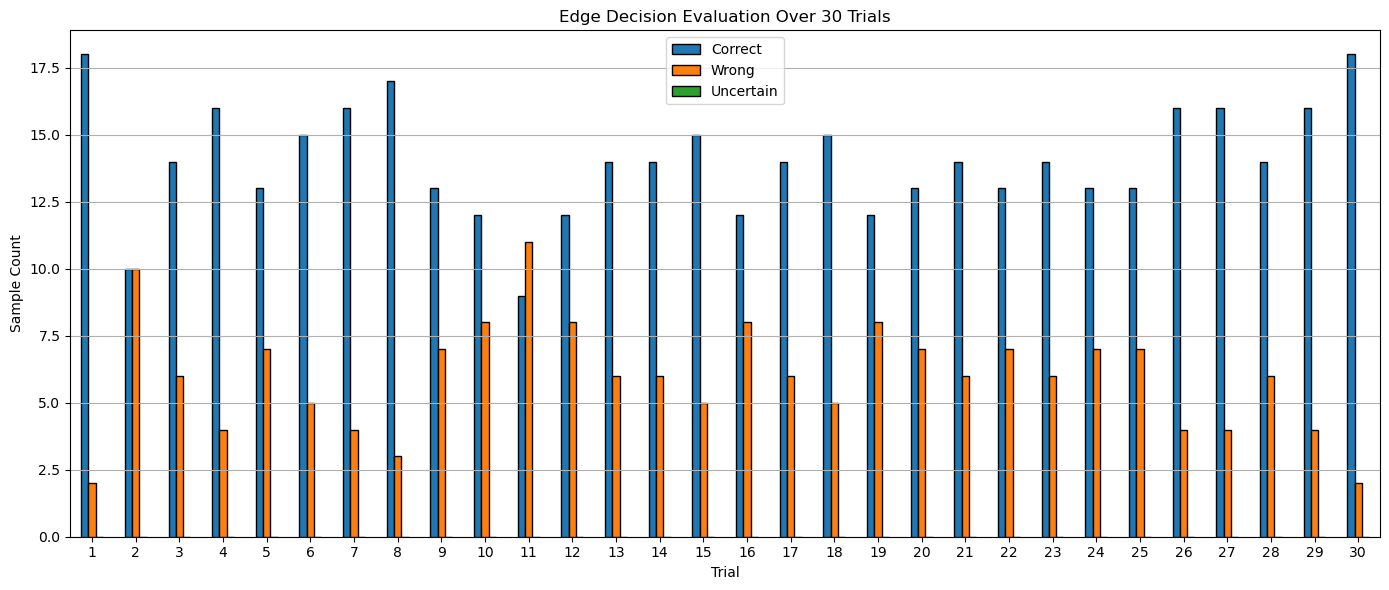

In [84]:

results_df = pd.DataFrame(results)

results_df.set_index("Trial")[["Correct", "Wrong", "Uncertain"]].plot(
    kind="bar", figsize=(14, 6), edgecolor="black")
plt.ylabel("Sample Count")
plt.title("Edge Decision Evaluation Over 30 Trials")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [85]:
avg_correct = results_df["Correct"].mean()
avg_wrong = results_df["Wrong"].mean()
avg_uncertain = results_df["Uncertain"].mean()

print(f"Avg Correct: {avg_correct:.2f}")
print(f"Avg Wrong: {avg_wrong:.2f}")
print(f"Avg Uncertain: {avg_uncertain:.2f}")

Avg Correct: 14.03
Avg Wrong: 5.97
Avg Uncertain: 0.00


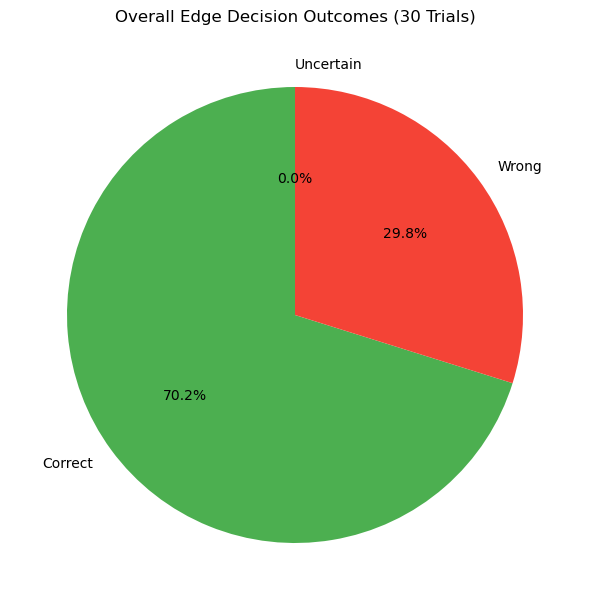

In [86]:

# Aggregate totals
total_counts = results_df[["Correct", "Wrong", "Uncertain"]].sum()

# Pie chart
plt.figure(figsize=(6, 9))
plt.pie(total_counts, labels=total_counts.index, autopct="%1.1f%%", startangle=90, colors=["#4CAF50", "#F44336", "#FFC107"])
plt.title("Overall Edge Decision Outcomes (30 Trials)")
plt.tight_layout()
plt.show()

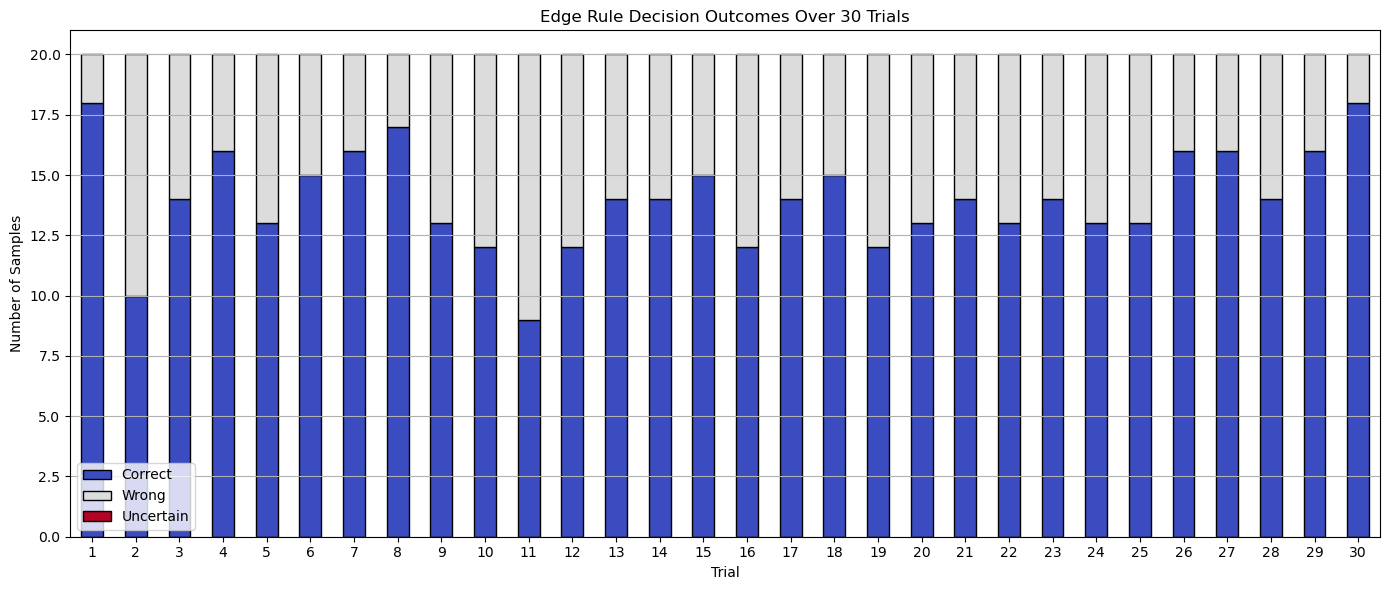

In [89]:
results_df.set_index("Trial")[["Correct", "Wrong", "Uncertain"]].plot(
    kind="bar", stacked=True, figsize=(14, 6), colormap="coolwarm", edgecolor="black"
)
plt.title("Edge Rule Decision Outcomes Over 30 Trials")
plt.ylabel("Number of Samples")
plt.xlabel("Trial")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

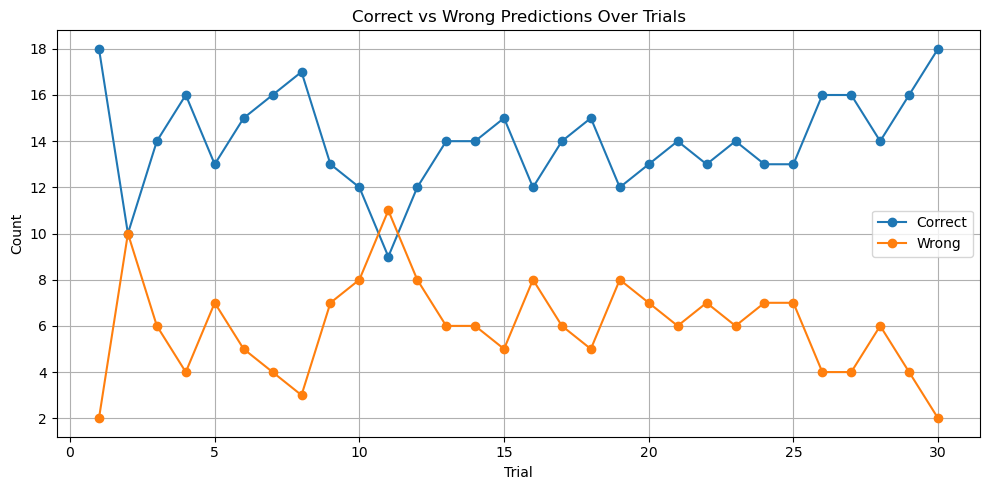

In [90]:
results_df.plot(x="Trial", y=["Correct", "Wrong"], kind="line", marker="o", figsize=(10, 5))
plt.title("Correct vs Wrong Predictions Over Trials")
plt.xlabel("Trial")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

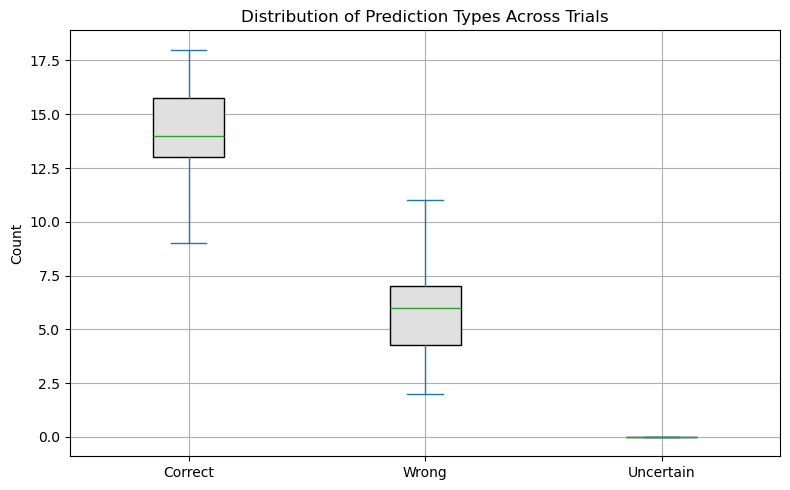

In [91]:
results_df[["Correct", "Wrong", "Uncertain"]].plot.box(figsize=(8, 5), patch_artist=True, boxprops=dict(facecolor="#E0E0E0"))
plt.title("Distribution of Prediction Types Across Trials")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()